In [1]:
import os

from pathlib import Path
from datetime import datetime
from calendar import monthrange

import fiona

import multiprocessing as mp

import geopandas as gpd


In [2]:
import sys
sys.path.append('/projects/my-private-bucket/code/icesat2_boreal/lib')
import plotlib
from mosaiclib import *

In [3]:
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Functions 
def wrapper_composite(params):

    FOCAL_TILE = params.get('FOCAL_TILE')
    SAT_API = params.get('SAT_API')
    MS_COMP_TYPE = params.get('MS_COMP_TYPE')
    YEAR = params.get('YEAR')
    MIN_N_FILT_RESULTS = params.get('MIN_N_FILT_RESULTS')
    SEASON_START = params.get('SEASON_START')
    SEASON_STOP = params.get('SEASON_STOP')
    # INDEX_FN = params.get('INDEX_FN')
    # INDEX_LYR = params.get('INDEX_LYR')
    
    STAT = params.get('STAT')
    STAT_PCT = params.get('STAT_PCT')
    TARGET_SPECTRAL = params.get('TARGET_SPECTRAL')

    INDEX_FN =  params.get('INDEX_FN') #'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg'
    INDEX_LYR = params.get('INDEX_LYR') # 'boreal_tiles_v004'
    
    YEAR_START, YEAR_STOP = (YEAR, YEAR)
    HLS_PRODUCT = params.get('HLS_PRODUCT') #HLS_PRODUCT = 'H30'
    MAX_CLOUDS = params.get('MAX_CLOUDS') #MAX_CLOUDS = 0

    OUTDIR = params.get('OUTDIR') #'/projects/my-private-bucket/tmp/mask_test_keep_snow'


    fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}{TARGET_SPECTRAL}.tif'
    if STAT == 'percentile':
        fn = f'{OUTDIR}/{MS_COMP_TYPE}_{FOCAL_TILE}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}_{STAT}{STAT_PCT}{TARGET_SPECTRAL}.tif'
    if os.path.exists(fn):
        print(f"{fn} already exists")
        return fn

        
    args = f"--in_tile_fn {INDEX_FN} \
        --in_tile_layer {INDEX_LYR} \
        --sat_api {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {FOCAL_TILE} \
        --output_dir {OUTDIR} \
        -sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} \
        --composite_type {MS_COMP_TYPE} \
        --hls_product {HLS_PRODUCT} \
        --thresh_min_ndvi -1 \
        --min_n_filt_results {MIN_N_FILT_RESULTS} \
        --stat {STAT} \
        --stat_pct {STAT_PCT} \
        --target_spectral_index {TARGET_SPECTRAL}"
    #args += " --do_indices"
    #args += " --search_only"
    #args += " --rangelims_red 0.01 0.1" # the default now effectively no limit [-1e9, 1e9]
    
    # cmd = f'python /projects/my-private-bucket/code/icesat2_boreal/lib/build_ms_composite.py {args}'
    cmd = f'python /projects/my-private-bucket/code/icesat2_boreal/lib/build_ms_composite_multip.py {args}'
    #!echo $cmd
    !eval $cmd

   
    #rescaled_multiband_fn = os.path.join(os.path.dirname(fn), os.path.basename(fn).replace('.tif','_rescaled_3band_temp.tif'))
    # plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [5,7,3], pct=[20,90], nodata=-9999.0) 

    return fn

In [5]:
# Set default parameters
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
MS_COMP_TYPE = 'HLS'
HLS_PRODUCT = 'H30'

STAT = 'max'
# STAT = 'percentile'
# STAT = 'median'

# TARGET_SPECTRAL = 'ndvi'
TARGET_SPECTRAL = 'evi2'
STAT_PCT = 50.0

MIN_N_FILT_RESULTS = 10
MAX_CLOUDS = 0


### Testing multiprocessing parallel

In [6]:
import multiprocessing as mp

num_cores = mp.cpu_count()
print(f"Number of CPU cores: {num_cores}")

import psutil

mem = psutil.virtual_memory()
print(f"Total memory: {mem.total / 1e9:.2f} GB")
print(f"Available memory: {mem.available / 1e9:.2f} GB")

Number of CPU cores: 32
Total memory: 267.33 GB
Available memory: 251.14 GB


In [7]:
# INDEX_FN = '/projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid30km_prj.gpkg' # Needs a tile_num column with the index and be in a projected coordinate system
INDEX_FN = '/projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg' # Needs a tile_num column with the index and be in a projected coordinate system
# Get first layer name
layer_names = fiona.listlayers(INDEX_FN)
# Get the first layer name
first_layer_name = layer_names[0]
INDEX_LYR = first_layer_name

BASE_OUTDIR = '/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi/'
# INDEX_LYR

params = {
    'SAT_API': SAT_API,
    'HLS_PRODUCT': HLS_PRODUCT,
    'MS_COMP_TYPE': MS_COMP_TYPE,
    'MAX_CLOUDS': MAX_CLOUDS,
    'MIN_N_FILT_RESULTS': MIN_N_FILT_RESULTS,
    'STAT': STAT,
    'STAT_PCT': STAT_PCT,
    'TARGET_SPECTRAL': TARGET_SPECTRAL,
    'INDEX_FN': INDEX_FN,
    'INDEX_LYR': INDEX_LYR,
}

In [8]:
# tiles = [1]#[5,10]  
# years = [2018, 2024]
years = [2022]

# All
with fiona.open(INDEX_FN, layer=0) as src:
    tiles = [feature["properties"]["tile_num"] for feature in src]
    
tiles_gpkg = gpd.read_file(INDEX_FN)
tiles = tiles_gpkg["tile_num"].tolist()
# # tiles

In [9]:
len(tiles)

220

In [10]:
# TEST
# tiles_run = tiles[0:1]
# tiles_run
# CPU times: user 560 ms, sys: 555 ms, total: 1.11 s
# Wall time: 5min 41s
# Only month 9 10 11 with valid results 

# Run 1
# tiles_run = tiles[1:3]
# tiles_run
# Run 1
tiles_run = tiles[0:50]


## Running all tiles 1 year multiprocess

In [11]:
outdirs = []

for tile in tiles_run: 
    for year in years:
        for month in range(1, 13):
            start_day = f"{month:02d}-01"
            end_day = f"{month:02d}-{monthrange(year, month)[1]:02d}"
            
            outdir = f'{BASE_OUTDIR}/tile_{tile:03d}/{year}/{month:02d}'
            outdirs.append(outdir)

outdirs[-1]

'/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi//tile_050/2022/12'

In [12]:
import copy

In [13]:
%%time
# Create parameter list and create output directories
params_list = []
for tile in tiles_run: 
    for year in years:
        # for month in range(2, 4):
        for month in range(1, 13):
            start_day = f"{month:02d}-01"
            end_day = f"{month:02d}-{monthrange(year, month)[1]:02d}"
    
            # output directory for specific run
            outdir = f'{BASE_OUTDIR}/tile_{tile:03d}/{year}/{month:02d}'
            # outdir = f'/projects/data/tmp/tile_{tile:03d}/{year}/{month:02d}'
            os.makedirs(outdir, exist_ok=True)
    
            run_params = copy.deepcopy(params)
            run_params.update({
                'FOCAL_TILE': tile,
                'YEAR': year,
                'SEASON_START': start_day,
                'SEASON_STOP': end_day,
                'OUTDIR': str(outdir)
            })
    
            params_list.append(run_params)



CPU times: user 57 ms, sys: 14.2 ms, total: 71.2 ms
Wall time: 20.2 s


In [14]:
# n_process = mp.cpu_count() - 1
# n_process

In [15]:
len(params_list)
# params_list[0]

600

In [16]:
# Name of folder is wrong because the composite is EVI based correct NDVI2

In [ ]:
%%time
fn_list = []
with mp.Pool(processes=10) as pool:
    fn_list = pool.map(wrapper_composite, params_list)

/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi//tile_009/2022/10/HLS_9_10-01_10-31_2022_2022_maxevi2.tif already exists
/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi//tile_011/2022/01/HLS_11_01-01_01-31_2022_2022_maxevi2.tif already exists
/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi//tile_006/2022/01/HLS_6_01-01_01-31_2022_2022_maxevi2.tif already exists
/projects/my-private-bucket/HLS/data/tif/monthly_composites90km_evi//tile_003/2022/07/HLS_3_07-01_07-31_2022_2022_maxevi2.tif already exists

Tiles path:		 /projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg
Tile number:		 12
Output res (m):		 30

Tiles path:		 /projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg
Tile number:		 8
Output res (m):		 30

Tiles path:		 /projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg
Tile number:		 7
Output res (m):		 30

Tiles path:		

In [18]:
# failed_params = [p for p, fn in zip(params_list, fn_list) if fn is None]
missing_fn_list = [fn for fn in fn_list if not os.path.exists(fn)]

In [ ]:
len(missing_fn_list)

In [ ]:
## 319
## 327
## 359
## 367
## 593
## 600

### Testing composite run

In [ ]:
# Create dictionary of params
params = {
    'SAT_API': SAT_API,
    'HLS_PRODUCT': HLS_PRODUCT,
    'MS_COMP_TYPE': MS_COMP_TYPE,
    'MAX_CLOUDS': MAX_CLOUDS,
    'MIN_N_FILT_RESULTS': MIN_N_FILT_RESULTS,
    'STAT': STAT,
    'STAT_PCT': STAT_PCT,
    'TARGET_SPECTRAL': TARGET_SPECTRAL,
    'INDEX_FN': INDEX_FN,
    'INDEX_LYR': INDEX_LYR,
}

In [29]:
# Define list of tiles and years 
# test
tiles_gpkg = gpd.read_file(INDEX_FN)
tiles = tiles_gpkg["tile_num"].tolist()
# tiles

tiles_run = tiles[2:3]  
years = [2022] #[2018, 2024]

# All

# with fiona.open(INDEX_FN, layer=0) as src:
#     tiles = [feature["properties"]["tile_num"] for feature in src]
tiles_run

[3]

In [30]:
# Create dictionary of params
params = {
    'SAT_API': SAT_API,
    'HLS_PRODUCT': HLS_PRODUCT,
    'MS_COMP_TYPE': MS_COMP_TYPE,
    'MAX_CLOUDS': MAX_CLOUDS,
    'MIN_N_FILT_RESULTS': MIN_N_FILT_RESULTS,
    'STAT': STAT,
    'STAT_PCT': STAT_PCT,
    'TARGET_SPECTRAL': TARGET_SPECTRAL,
    'INDEX_FN': INDEX_FN,
    'INDEX_LYR': INDEX_LYR,
}

In [31]:
# params.update({
#                 'FOCAL_TILE': 10,
#                 'YEAR': 2022,
#                 'SEASON_START': '05-01',
#                 'SEASON_STOP': '08-01',
#                 'OUTDIR': str(BASE_OUTDIR)
#             })


# fn = wrapper_composite(params)

In [32]:
# for tile in tiles:
#     for year in years:
#         for month in range(2, 4):
#             # print(tile,year,month)
#             outdir = f'{BASE_OUTDIR}/tile_{tile}/{year}/{month:02d}'
#             print(outdir)



In [33]:
# BASE_OUTDIR

In [ ]:
%%time
for tile in tiles:
    for year in years:
        for month in range(2, 4):
        # for month in range(1, 13):
            start_day = f"{month:02d}-01"
            end_day = f"{month:02d}-{monthrange(year, month)[1]:02d}"

            # Compose output directory for this specific run
            outdir = f'{BASE_OUTDIR}/tile_{tile:03d}/{year}/{month:02d}'
            os.makedirs(outdir, exist_ok=True)

            params.update({
                'FOCAL_TILE': tile,
                'YEAR': year,
                'SEASON_START': start_day,
                'SEASON_STOP': end_day,
                'OUTDIR': str(outdir)
            })

            try:
                print(f"Running tile {tile}, year {year}, month {month:02d}")
                output_file = wrapper_composite(params)
                print(f"Output saved to: {output_file}")
            except Exception as e:
                print(f"Error processing tile {tile}, year {year}, month {month:02d}: {e}")

Running tile 1, year 2022, month 02
^C
Traceback (most recent call last):
  File "/projects/my-private-bucket/code/icesat2_boreal/lib/build_ms_composite_multip.py", line 3, in <module>
    import geopandas as gpd
  File "/opt/conda/envs/pangeo/lib/python3.12/site-packages/geopandas/__init__.py", line 3, in <module>
    from geopandas.geoseries import GeoSeries
  File "/opt/conda/envs/pangeo/lib/python3.12/site-packages/geopandas/geoseries.py", line 9, in <module>
    import pandas as pd
  File "/opt/conda/envs/pangeo/lib/python3.12/site-packages/pandas/__init__.py", line 49, in <module>
    from pandas.core.api import (
  File "/opt/conda/envs/pangeo/lib/python3.12/site-packages/pandas/core/api.py", line 28, in <module>
    from pandas.core.arrays import Categorical
  File "/opt/conda/envs/pangeo/lib/python3.12/site-packages/pandas/core/arrays/__init__.py", line 1, in <module>
    from pandas.core.arrays.arrow import ArrowExtensionArray
  File "/opt/conda/envs/pangeo/lib/python3.12/sit

In [34]:
output_file = '/projects/my-private-bucket/HLS/data/tif/monthly_composites_evi/tile_001/2022/03/HLS_1_03-01_03-31_2022_2022_maxevi2.tif'

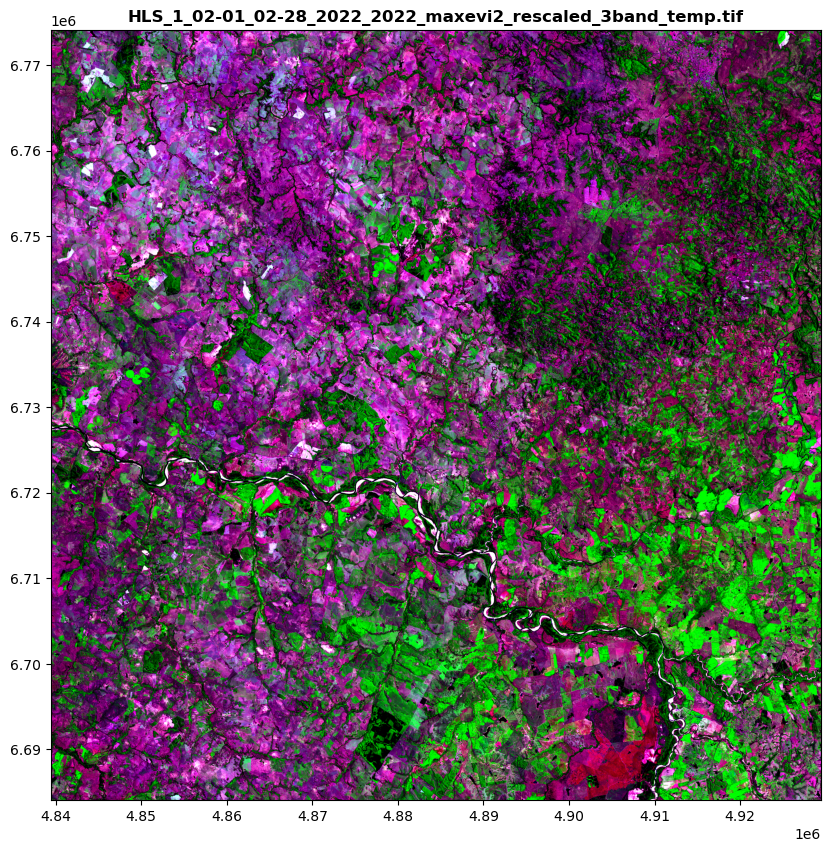

In [35]:
rescaled_multiband_fn = output_file.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(output_file, rescaled_multiband_fn, bandlist = [6,4,3], pct=[20,98], nodata=-9999.0) 


fig,ax=plt.subplots(figsize=(10,10))
with rasterio.open(rescaled_multiband_fn) as src:
    #print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))

In [23]:
fn = fn_list[0]
fn

'/projects/HLS/data/tif/monthly_composites/tile_5/2018/02/HLS_5_02-01_02-28_2018_2018_maxndvi.tif'

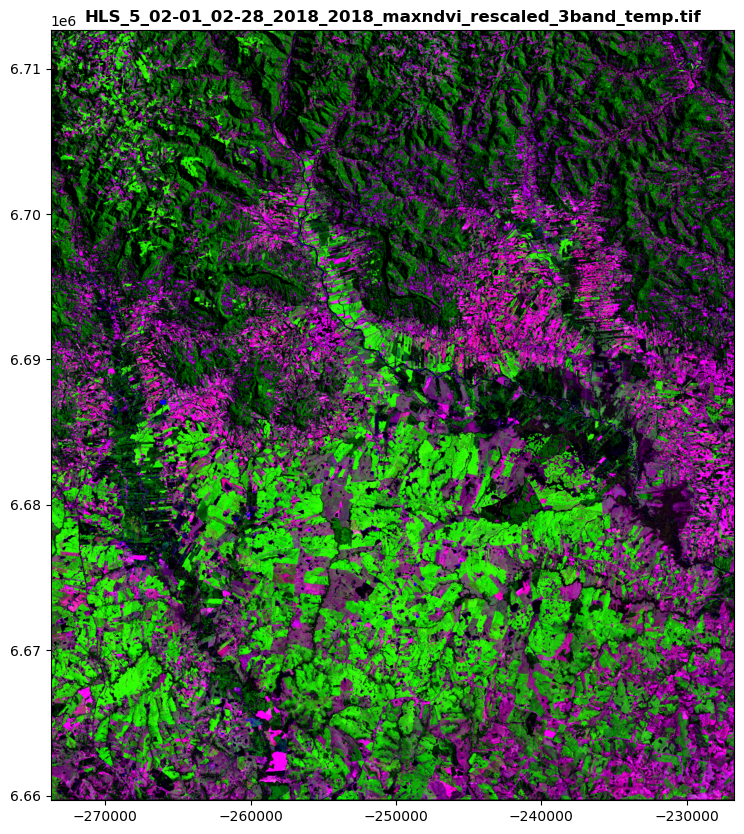

In [27]:
rescaled_multiband_fn = fn.replace('.tif', '_rescaled_3band_temp.tif')

plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [6,4,3], pct=[20,98], nodata=-9999.0) 


fig,ax=plt.subplots(figsize=(10,10))
with rasterio.open(rescaled_multiband_fn) as src:
    #print(src.profile)
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(rescaled_multiband_fn))